In [1]:
# '''
# #Sequence to sequence example in Keras (character-level).

# This script demonstrates how to implement a basic character-level
# sequence-to-sequence model. We apply it to translating
# short English sentences into short French sentences,
# character-by-character. Note that it is fairly unusual to
# do character-level machine translation, as word-level
# models are more common in this domain.

# **Summary of the algorithm**

# - We start with input sequences from a domain (e.g. English sentences)
#     and corresponding target sequences from another domain
#     (e.g. French sentences).
# - An encoder LSTM turns input sequences to 2 state vectors
#     (we keep the last LSTM state and discard the outputs).
# - A decoder LSTM is trained to turn the target sequences into
#     the same sequence but offset by one timestep in the future,
#     a training process called "teacher forcing" in this context.
#     It uses as initial state the state vectors from the encoder.
#     Effectively, the decoder learns to generate `targets[t+1...]`
#     given `targets[...t]`, conditioned on the input sequence.
# - In inference mode, when we want to decode unknown input sequences, we:
#     - Encode the input sequence into state vectors
#     - Start with a target sequence of size 1
#         (just the start-of-sequence character)
#     - Feed the state vectors and 1-char target sequence
#         to the decoder to produce predictions for the next character
#     - Sample the next character using these predictions
#         (we simply use argmax).
#     - Append the sampled character to the target sequence
#     - Repeat until we generate the end-of-sequence character or we
#         hit the character limit.

# **Data download**

# [English to French sentence pairs.
# ](http://www.manythings.org/anki/fra-eng.zip)

# [Lots of neat sentence pairs datasets.
# ](http://www.manythings.org/anki/)

# **References**

# - [Sequence to Sequence Learning with Neural Networks
#    ](https://arxiv.org/abs/1409.3215)
# - [Learning Phrase Representations using
#     RNN Encoder-Decoder for Statistical Machine Translation
#     ](https://arxiv.org/abs/1406.1078)
# '''

In [2]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

Using TensorFlow backend.


In [3]:
batch_size = 64  # Batch size for training.
epochs = 100 # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '../data/text/rus-eng/rus.txt'

In [4]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'rt', encoding='utf-8') as f:
    lines = f.read().split('\n')
    
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 72
Number of unique output tokens: 92
Max sequence length for inputs: 14
Max sequence length for outputs: 60


In [5]:
# input_token_index = dict( [(char, i) for i, char in enumerate(input_characters)])
# target_token_index = dict( [(char, i) for i, char in enumerate(target_characters)])

input_token_index = { char:i for i, char in enumerate(input_characters) }
target_token_index = { char:i  for i, char in enumerate(target_characters) }

In [6]:
# input_token_index
# target_token_index

In [7]:
encoder_input_data = np.zeros( (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros( (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

In [8]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
        
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [9]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 72)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 92)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 336896      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  357376      input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [11]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [12]:
%%time 

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 25s 3ms/step - loss: 0.7440 - val_loss: 0.7862
Epoch 2/10
8000/8000 [==============================] - 24s 3ms/step - loss: 0.6189 - val_loss: 0.6523
Epoch 3/10
8000/8000 [==============================] - 24s 3ms/step - loss: 0.5311 - val_loss: 0.6008
Epoch 4/10
8000/8000 [==============================] - 24s 3ms/step - loss: 0.4898 - val_loss: 0.5688
Epoch 5/10
8000/8000 [==============================] - 24s 3ms/step - loss: 0.4603 - val_loss: 0.5531
Epoch 6/10
8000/8000 [==============================] - 24s 3ms/step - loss: 0.4352 - val_loss: 0.5275
Epoch 7/10
8000/8000 [==============================] - 24s 3ms/step - loss: 0.4144 - val_loss: 0.5183
Epoch 8/10
8000/8000 [==============================] - 24s 3ms/step - loss: 0.3959 - val_loss: 0.5061
Ep

In [13]:
# Save model
# model.save('s2s.h5')

---

In [14]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model( [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [15]:
# Reverse-lookup token index to decode sequences back to something readable.
# reverse_input_char_index = dict(  (i, char) for char, i in input_token_index.items())
# reverse_target_char_index = dict( (i, char) for char, i in target_token_index.items())

reverse_input_char_index = { i:char for char,i in input_token_index.items() }
reverse_target_char_index = { i:char for char,i in target_token_index.items() }

In [16]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [17]:
ii = np.random.permutation(len(encoder_input_data))[:100]
for seq_index in ii:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print( input_texts[seq_index],' -> ', decoded_sentence)

You're fired.  ->  Ты страсный.

I'm so proud.  ->  Я не постраен.

He relented.  ->  Он пострелил.

It's fun.  ->  Это странно.

They help us.  ->  Они победили.

You're vain.  ->  Ты страсный.

Ask around.  ->  Подерь это.

Stop here.  ->  Постаньте его.

We're inside.  ->  Мы победием.

I apologize.  ->  Я пострали.

It was useful.  ->  Это было прасто.

I'm cured.  ->  Я не постраен.

Go back home.  ->  Иди за мно.

Replace it.  ->  Поделжайтесь.

He made me go.  ->  Он пострали.

I'll miss Tom.  ->  Я пострали.

He dug a hole.  ->  Он пострали.

We're scared.  ->  Мы победием.

Don't forget.  ->  Не простивей.

Wake them up.  ->  Подолжайте споть.

Stay there.  ->  Поделжайтесь.

I need a hat.  ->  Я победула.

We feel safe.  ->  Мы победили.

Keep trying.  ->  Продолжайте споть.

Smell this.  ->  Позволи Тома.

It works.  ->  Это было прасто.

Pick him up.  ->  Подомите его.

Who'll come?  ->  Кто победил?

I'm thin.  ->  Я не постраен.

I'm a singer.  ->  Я не постраен.

Was I w

In [18]:
# for seq_index in range(100):
#     # Take one sequence (part of the training set)
#     # for trying out decoding.
#     input_seq = encoder_input_data[seq_index: seq_index + 1]
#     decoded_sentence = decode_sequence(input_seq)
#     print('-')
#     print('Input sentence:', input_texts[seq_index])
#     print('Decoded sentence:', decoded_sentence)

---

In [19]:
import matplotlib.pyplot as plt

In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'loss'])

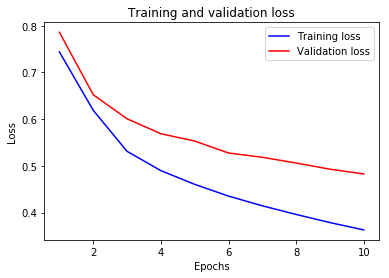

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
# plt.clf()   # clear figure
# acc_values = history_dict['acc']
# val_acc_values = history_dict['val_acc']

# plt.plot(epochs, acc, 'b', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()